In [16]:
# Ref: https://jaromiru.com/2016/10/03/lets-make-a-dqn-implementation/

import os

import random, numpy, math, gym
from matplotlib import pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as I

In [26]:
#-------------------- BRAIN ---------------------------
class DQN(nn.Module):

    def __init__(self, stateCnt, actionCnt):
        super(DQN, self).__init__()
        self.stateCnt = stateCnt
        self.actionCnt = actionCnt
        self.fc1 = nn.Linear(in_features=stateCnt, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=actionCnt)
#         I.kaiming_uniform_(self.fc1.weight)  # Kaiming seems to be better than Xavier
#         I.kaiming_uniform_(self.fc2.weight)

    def forward(self, x):
#         print(type(x))
        x = F.relu(self.fc1(x))
        return self.fc2(x)


class Brain:

    def __init__(self, stateCnt, actionCnt):
        self.stateCnt = stateCnt
        self.actionCnt = actionCnt

        self.model = self._createModel(stateCnt, actionCnt)
        
        self.optimizer = optim.RMSprop(self.model.parameters(), lr=0.00025, eps=1E-7, alpha=0.9, centered=False, weight_decay=0.0)
        self.criterion = nn.MSELoss()

    def _createModel(self, stateCnt, actionCnt):
        model = DQN(stateCnt, actionCnt)
        return model

    def train(self, x, y, epoch=1, verbose=0):
        self.model.train()
        self.optimizer.zero_grad()
        output = self.model(x)
        target = y
        loss = self.criterion(output, target)
        loss.backward()
        self.optimizer.step()

    def predict(self, s):
        self.model.eval()
        return self.model(s)

    def predictOne(self, s):
        self.model.eval()
        return self.model(s)

#-------------------- MEMORY --------------------------
class Memory:   # stored as ( s, a, r, s_ )

    def __init__(self, capacity):
        self.samples = []
        self.capacity = capacity
        
    def __len__(self):
        return len(self.samples)

    def add(self, sample):
        self.samples.append(sample)        

        if len(self) > self.capacity:
            self.samples.pop(0)

    def sample(self, n):
        n = min(n, len(self.samples))
        return random.sample(self.samples, n)

#-------------------- AGENT ---------------------------
MEMORY_CAPACITY = 100000
BATCH_SIZE = 64

GAMMA = 0.99

MAX_EPSILON = 1
MIN_EPSILON = 0.01
LAMBDA = 0.001      # speed of decay

class Agent:
    steps = 0
    epsilon = MAX_EPSILON

    def __init__(self, stateCnt, actionCnt, exhibition_mode=False):
        self.stateCnt = stateCnt
        self.actionCnt = actionCnt

        self.brain = Brain(stateCnt, actionCnt)
        self.memory = Memory(MEMORY_CAPACITY)
        
        self.exhibition_mode = exhibition_mode
        
        if self.exhibition_mode:
            brain_wts = 'cartpole-basic.torch'
            if os.path.exists(brain_wts):
                self.brain.model.load_state_dict(torch.load('cartpole-basic.torch'))

        
    def act(self, s):
        max_pred = int(torch.argmax(self.brain.predictOne(s)))
        # Always select the best action
        if self.exhibition_mode:
            return max_pred
        # Espsilon greedy
        if random.random() < self.epsilon:
            return random.randint(0, self.actionCnt-1)
        else:
            return max_pred

    def observe(self, sample):  # in (s, a, r, s_) format
        self.memory.add(sample)        

        # slowly decrease Epsilon based on our eperience
        self.steps += 1
        self.epsilon = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * self.steps)

    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return

#         print('Training ...')
        batch = self.memory.sample(BATCH_SIZE)
        batchLen = len(batch)

        no_state = torch.zeros(self.stateCnt)
        
#         print(type(batch[0]))
        states = torch.stack([ o[0] for o in batch ])
        states_ = torch.stack([ (no_state if o[3] is None else o[3]) for o in batch ])
        
        states = states.reshape(batchLen, -1)
        states_ = states_.reshape(batchLen, -1)

        p = self.brain.predict( states )
        p_ = self.brain.predict( states_ )
        
#         print('p', p)
#         print('p_', p_)

        x = torch.zeros((batchLen, self.stateCnt))
        y = torch.zeros((batchLen, self.actionCnt))

        for i in range(0, batchLen):
#             print(i)
            o = batch[i]
            s = o[0]; a = o[1]; r = o[2]; s_ = o[3]

            t = p[i]
#             print('a', a)
#             print('type(a)', type(a))
#             print('t', t)
#             print('t[a]', t[a])
            if s_ is None:
                t[a] = r
            else:
                t[a] = r + GAMMA * float(max(p_[i]))
#                 print(t[a])

            x[i] = s
            y[i] = t
#         print(type(x), type(y))
        x = x.reshape(batchLen, -1)
        y = y.reshape(batchLen, -1)
        self.brain.train(x, y)

#-------------------- ENVIRONMENT ---------------------
class Environment:
    def __init__(self, problem):
        self.problem = problem
        self.env = gym.make(problem)

    def run(self, agent):
        s = self.env.reset()
        s = torch.from_numpy(s).float()
        R = 0

        while True:         
#             self.env.render()

            a = agent.act(s)

            s_, r, done, info = self.env.step(a)
            s_ = torch.from_numpy(s_).float()

            if done: # terminal state
                s_ = None

            # Observe and train, but don't if in exhibition mode
            if not agent.exhibition_mode:
                agent.observe( (s, a, r, s_) )
                agent.replay()

            s = s_
            R += r

            if done:
                break

        return R

#-------------------- MAIN ----------------------------

PROBLEM = 'CartPole-v0'
env = Environment(PROBLEM)

stateCnt  = env.env.observation_space.shape[0]
actionCnt = env.env.action_space.n

# # Training mode
# agent = Agent(stateCnt, actionCnt, exhibition_mode=False)

# Exhibition mode
agent = Agent(stateCnt, actionCnt, exhibition_mode=True)

episode_rewards = []

try:
    while True:
        R = env.run(agent)
        episode_rewards.append(R)
        print("[{:05d}] Total reward: {}".format(len(episode_rewards), R))
        
finally:
    if not agent.exhibition_mode:
        torch.save(agent.brain.model.state_dict(), 'cartpole-basic.torch')


[00001] Total reward: 200.0
[00002] Total reward: 200.0
[00003] Total reward: 200.0
[00004] Total reward: 200.0
[00005] Total reward: 200.0
[00006] Total reward: 200.0
[00007] Total reward: 192.0
[00008] Total reward: 200.0
[00009] Total reward: 200.0
[00010] Total reward: 200.0
[00011] Total reward: 169.0
[00012] Total reward: 191.0
[00013] Total reward: 200.0
[00014] Total reward: 200.0
[00015] Total reward: 200.0
[00016] Total reward: 200.0
[00017] Total reward: 200.0
[00018] Total reward: 200.0
[00019] Total reward: 200.0
[00020] Total reward: 200.0
[00021] Total reward: 200.0
[00022] Total reward: 170.0
[00023] Total reward: 193.0
[00024] Total reward: 200.0
[00025] Total reward: 200.0
[00026] Total reward: 200.0
[00027] Total reward: 152.0
[00028] Total reward: 200.0
[00029] Total reward: 200.0
[00030] Total reward: 200.0
[00031] Total reward: 200.0
[00032] Total reward: 200.0
[00033] Total reward: 200.0
[00034] Total reward: 200.0
[00035] Total reward: 177.0
[00036] Total reward

KeyboardInterrupt: 

Text(0, 0.5, 'Episode reward')

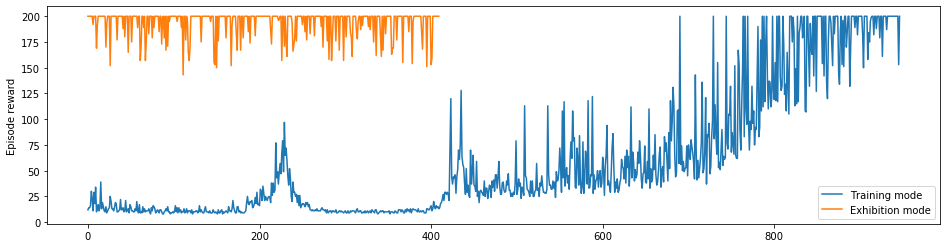

In [27]:
if not agent.exhibition_mode:
    naive_episode_rewards = episode_rewards[:]


fig, ax = plt.subplots()
fig.set_size_inches((16, 4))
ax.plot(naive_episode_rewards, label='Training mode')
ax.legend()

ax.plot(episode_rewards, label='Exhibition mode')
ax.legend()

ax.set_ylabel('Episode reward')